In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 


# Functions: data loading, concat + filter/trim the data, calculate results

In [ ]:
indices = ['sp500', 'ftse100', 'nikkei225']
data_dir = r"C:\\physics_masters\\data\\"


def load_data(index):
    data_subdir = os.path.join(data_dir, index)
    dataframes = []
    for filename in os.listdir(data_subdir):
        path = os.path.join(data_subdir, filename)
        name = filename.replace('.csv', '')

        df = pd.read_csv(path, delimiter=',', skiprows=3, header=0, names = ['Date', 'Close','High','Low','Open','Volume'], parse_dates=['Date'], usecols=['Date', 'Close'])
        df.set_index('Date', inplace=True)
        df.rename(columns={"Close": name}, inplace=True)

        dataframes.append(df)
    return dataframes

def concat_dfs_by_date(dataframes):
    df_concat = pd.concat(dataframes, axis=1)
    df_concat.index = df_concat.index.astype(dataframes[0].index.dtype)
    
    #only stocks with many time points
    q20 = df_concat.count().quantile(0.2).astype(int)
    df_concat = df_concat.loc[:, df_concat.count() >= q20]

    #outliers
    qhigh = df_concat.quantile(0.995)
    qlow = df_concat.quantile(0.005)
    df_concat[df_concat > qhigh] = np.nan
    df_concat[df_concat < qlow] = np.nan

    df_concat.ffill(inplace=True)
    df_concat = df_concat.pct_change(fill_method=None) ### mam robić return jako różnicę czy return procentowy?
    df_concat = (df_concat - df_concat.mean()) /df_concat.std() # i tak używają tylko daszków
    return df_concat

def LI(df, tau_list):  # influence shifted forward by tau! 
    LI_tau = []

    I = df.mean(axis=1)
    I2 = I**2

    for tau in tau_list:        

        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * I2).mean()

        LI_tau.append(corr_mean/I2_mean)
    return pd.Series(LI_tau, index=tau_list, name='LI_tau')

def Lsigma(df, tau_list):
    Lsigma_tau = []

    I = df.mean(axis=1)
    I2 = I**2

    for tau in tau_list:        

        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * (df**2).mean(axis=1)).mean()

        Lsigma_tau.append(corr_mean/I2_mean)
    return pd.Series(Lsigma_tau, index=tau_list, name='Lsigma_tau')

# def stocks_correlations_sum(df): #liczy się 20 sek dla sp500
#     rho = []
#     T, N = df.shape

#     matrices = np.einsum('ti,tj->tij', df, df)

#     triu_mask = np.triu(np.ones((N, N), dtype=bool), k=1)
    
#     pairwise_sums = matrices[:, triu_mask].sum(axis=1) 

#     return pd.Series(pairwise_sums, index=df.index, name='rho_corr_sum')

# def rho(df):
#     corrs = stocks_correlations_sum(df)
#     sigma2 = (df**2).mean(axis=1)
#     N = df.shape[1]
#     rho = corrs / (sigma2 * N * (N-1)) *2
#     return rho

def rho(df):
    N = df.shape[1]
    I = df.mean(axis=1)  
    sigma2 = (df**2).mean(axis=1)  

    numerator = (I**2 * N**2) - (N * sigma2)
    denominator = N * (N - 1) * sigma2

    rho_t = numerator / denominator
    return rho_t


def Lrho(df, tau_list):
    Lrho_tau = []

    I = (df).mean(axis=1)
    I2 = I**2

    rho_vals = rho(df)

    for tau in tau_list:    
        
        I2_mean = I2.mean() # I2_mean = I2.shift(periods=-tau).mean()

        corr_mean = (I.shift(periods=tau) * rho_vals).mean()

        Lrho_tau.append(corr_mean/I2_mean)
    return pd.Series(Lrho_tau, index=tau_list, name='Lrho_tau')

# SP500 results

In [98]:
dataframes = load_data('sp500')


In [ ]:
df_concat = concat_dfs_by_date(dataframes)

In [100]:
tau_list = np.arange(0, 100, 1)

rho_0 = rho(df_concat).mean()
sigma2_0 = (df_concat**2).mean(axis=1).mean()
LI_vals = LI(df_concat, tau_list)
Lsigma_vals = Lsigma(df_concat, tau_list)
Lrho_vals = Lrho(df_concat, tau_list)


In [102]:
rho_0*sigma2_0

np.float64(0.2063682070486171)

In [104]:
(((df_concat).mean(axis=1))**2).mean()

np.float64(0.3558433219178563)

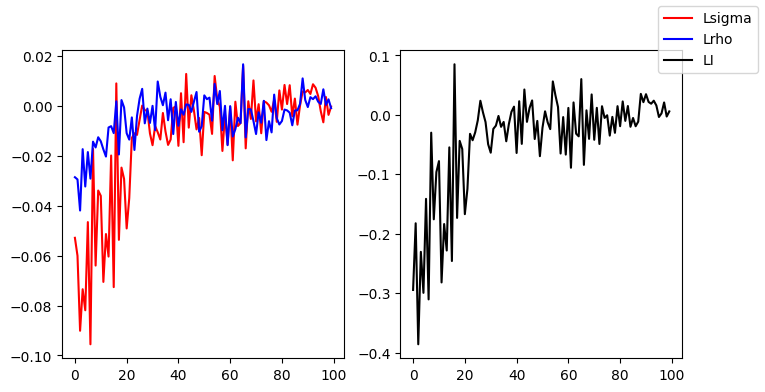

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

LI_vals.plot(ax=ax[1], label='LI', color='black')
(Lsigma_vals*rho_0).plot(ax=ax[0], label='Lsigma', color='red')
(Lrho_vals*sigma2_0).plot(ax=ax[0], label='Lrho', color='blue')

fig.legend()

# SP500 and FTSE100

In [119]:
indices = ['sp500', 'ftse100']


dataframes = []
for index in indices:
    dataframes += load_data(index)
df_concat = concat_dfs_by_date(dataframes)


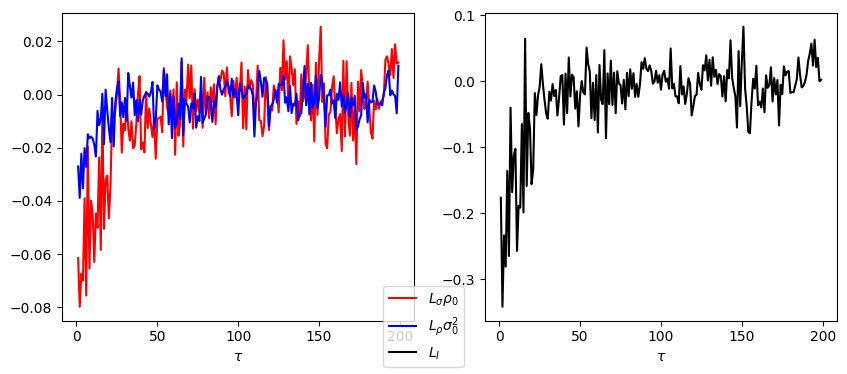

In [127]:
tau_list = np.arange(1, 200, 1)
rho_0 = rho(df_concat).mean()
sigma2_0 = (df_concat**2).mean(axis=1).mean()
LI_vals = LI(df_concat, tau_list)
Lsigma_vals = Lsigma(df_concat, tau_list)
Lrho_vals = Lrho(df_concat, tau_list)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
LI_vals.plot(ax=ax[1], label=r'$L_I$', color='black')
(Lsigma_vals*rho_0).plot(ax=ax[0], label=r'$L_{\sigma}\rho_0$', color='red')
(Lrho_vals*sigma2_0).plot(ax=ax[0], label=r'$L_{\rho}\sigma_0^2$', color='blue')
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')

fig.legend(loc='lower center')

In [128]:
df_concat.shape

(3856, 517)